# Clustering Notebook

We import some packages and our dataset.

In [ ]:
!pip install --upgrade plotly
!pip install geopandas
!pip install sklearn

import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from itertools import product 
from geopandas import GeoDataFrame
from shapely.geometry import Point
import plotly.express as px
import plotly.graph_objects as go
import geopy.distance
import seaborn as sns 


!gdown https://drive.google.com/uc?id=1Jpz2zP4-gU8aN7hiF0e6GhFhnRMm1zTl

!unzip "/content/BA.zip" #should be changed to path where zip is downloaded (this line works if used on Colab)

     |████████████████████████████████| 25.3 MB 1.8 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
     |████████████████████████████████| 1.0 MB 4.2 MB/s 
     |████████████████████████████████| 6.3 MB 29.3 MB/s 
     |████████████████████████████████| 15.4 MB 33.0 MB/s 
Downloading...
From: https://drive.google.com/uc?id=1Jpz2zP4-gU8aN7hiF0e6GhFhnRMm1zTl
To: /content/BA.zip
100% 90.0M/90.0M [00:02<00:00, 37.1MB/s]
Archive:  /content/BA.zip
  inflating: 202011-capitalbikeshare-tripdata.csv  
  inflating: __MACOSX/._202011-capitalbikeshare-tripdata.csv  
  inflating: 202012-capitalbikeshare-tripdata.csv  
  inflating: __MACOSX/._202012-capitalbikeshare-tripdata.csv  
  inflating: 202101-capitalbikeshare-tripdata.csv  
  inflating: __MACOSX/._202101-capitalbikeshare-tripdata.csv  
  inflating: 202102-capitalbikeshare-tripdata.csv  
  inflating: __MACOSX/._202102-capitalbikeshar

We import our data

In [ ]:
weather=pd.read_csv("/content/history_data.csv") #Again path has to be changed if not on Colab
nov = pd.read_csv("/content/202011-capitalbikeshare-tripdata.csv")
dec = pd.read_csv("/content/202012-capitalbikeshare-tripdata.csv")
jan = pd.read_csv("/content/202101-capitalbikeshare-tripdata.csv")
feb = pd.read_csv("/content/202102-capitalbikeshare-tripdata.csv")
mar = pd.read_csv("/content/202103-capitalbikeshare-tripdata.csv")
apr = pd.read_csv("/content/202104-capitalbikeshare-tripdata.csv")
may = pd.read_csv("/content/202105-capitalbikeshare-tripdata.csv")
jun = pd.read_csv("/content/202106-capitalbikeshare-tripdata.csv")
jul = pd.read_csv("/content/202107-capitalbikeshare-tripdata.csv")
aug = pd.read_csv("/content/202108-capitalbikeshare-tripdata.csv")
sep = pd.read_csv("/content/202109-capitalbikeshare-tripdata.csv")
oct = pd.read_csv("/content/202110-capitalbikeshare-tripdata.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Weather dataset prep

In [ ]:
weather.head()

,Name,Date time,Maximum Temperature,Minimum Temperature,Temperature,Wind Chill,Heat Index,Precipitation,Snow,Snow Depth,Wind Speed,Wind Direction,Wind Gust,Visibility,Cloud Cover,Relative Humidity,Conditions
0,"Washington, DC, United States",02/01/2021 00:00:00,-0.7,-0.7,-0.7,-6.9,NaN,0.0,0.00,4.02,25.3,21.0,NaN,6.5,100.0,90.20,Overcast
1,"Washington, DC, United States",02/01/2021 01:00:00,-0.7,-0.7,-0.7,-6.6,NaN,0.0,0.17,4.18,23.0,19.0,27.7,10.5,100.0,90.05,"Snow, Overcast"
2,"Washington, DC, United States",02/01/2021 02:00:00,-0.7,-0.7,-0.7,-7.0,NaN,0.0,0.17,4.35,26.3,19.0,NaN,13.2,100.0,89.94,"Snow, Overcast"
3,"Washington, DC, United States",02/01/2021 03:00:00,-0.7,-0.7,-0.7,-6.3,NaN,0.0,0.17,4.52,21.6,9.0,25.9,11.5,100.0,90.00,"Snow, Overcast"
4,"Washington, DC, United States",02/01/2021 04:00:00,-0.7,-0.7,-0.7,-6.3,NaN,0.0,0.17,4.68,21.7,351.0,NaN,8.6,100.0,89.81,"Snow, Overcast"


In [ ]:
weather.describe()

,Maximum Temperature,Minimum Temperature,Temperature,Wind Chill,Heat Index,Precipitation,Snow,Snow Depth,Wind Speed,Wind Direction,Wind Gust,Visibility,Cloud Cover,Relative Humidity
count,2112.000000,2112.000000,2112.000000,1065.000000,26.000000,2112.000000,2112.000000,2112.000000,2112.000000,2110.000000,546.000000,2112.000000,2112.000000,2112.000000
mean,9.290436,9.290436,9.290436,0.277465,27.703846,0.119479,0.009271,0.299427,14.699479,196.015166,43.013004,14.798343,65.169223,58.359493
std,7.154686,7.154686,7.154686,4.789921,0.910596,0.617944,0.143992,1.128693,8.448478,115.756496,10.164435,3.075644,35.515544,22.231695
min,-3.800000,-3.800000,-3.800000,-10.200000,26.600000,0.000000,0.000000,0.000000,0.000000,0.000000,25.900000,1.000000,0.000000,14.210000
25%,3.200000,3.200000,3.200000,-3.800000,27.000000,0.000000,0.000000,0.000000,8.900000,91.000000,35.300000,16.000000,24.800000,40.660000
50%,8.850000,8.850000,8.850000,0.300000,27.500000,0.000000,0.000000,0.000000,13.300000,195.000000,42.500000,16.000000,81.300000,55.845000
75%,14.300000,14.300000,14.300000,4.500000,28.075000,0.000000,0.000000,0.000000,20.025000,310.000000,50.000000,16.000000,98.800000,77.455000
max,29.900000,29.900000,29.900000,9.600000,30.000000,11.840000,4.090000,8.000000,58.500000,360.000000,86.700000,16.000000,100.000000,100.000000


We convert `date` and `time` from string to a date/type format.

In [ ]:
weather['date'] = pd.to_datetime(weather['Date time']).dt.date
weather['time'] = pd.to_datetime(weather['Date time']).dt.time

We encode the `conditions` variable.

In [ ]:
le = preprocessing.LabelEncoder()
weather["Conditions_enc"] = le.fit_transform(weather["Conditions"])

We remove columns that are not useful.

In [ ]:
weather = weather.drop(columns=["Minimum Temperature","Maximum Temperature","Heat Index"])

All remaing NA in the dataset represent a phenomen, e.g. rain, that didn't happen. We thus replace them with 0s.

In [ ]:
weather = weather.fillna(0)

In [ ]:
weather.head()

,Name,Date time,Temperature,Wind Chill,Precipitation,Snow,Snow Depth,Wind Speed,Wind Direction,Wind Gust,Visibility,Cloud Cover,Relative Humidity,Conditions,date,time,Conditions_enc
0,"Washington, DC, United States",02/01/2021 00:00:00,-0.7,-6.9,0.0,0.00,4.02,25.3,21.0,0.0,6.5,100.0,90.20,Overcast,2021-02-01,00:00:00,1
1,"Washington, DC, United States",02/01/2021 01:00:00,-0.7,-6.6,0.0,0.17,4.18,23.0,19.0,27.7,10.5,100.0,90.05,"Snow, Overcast",2021-02-01,01:00:00,6
2,"Washington, DC, United States",02/01/2021 02:00:00,-0.7,-7.0,0.0,0.17,4.35,26.3,19.0,0.0,13.2,100.0,89.94,"Snow, Overcast",2021-02-01,02:00:00,6
3,"Washington, DC, United States",02/01/2021 03:00:00,-0.7,-6.3,0.0,0.17,4.52,21.6,9.0,25.9,11.5,100.0,90.00,"Snow, Overcast",2021-02-01,03:00:00,6
4,"Washington, DC, United States",02/01/2021 04:00:00,-0.7,-6.3,0.0,0.17,4.68,21.7,351.0,0.0,8.6,100.0,89.81,"Snow, Overcast",2021-02-01,04:00:00,6


# Rides dataset prep

We combine all the rides' monthly datasets into a single one.

In [ ]:
rides=pd.concat([nov,dec,jan,feb,mar,apr,may,jun,jul,aug,sep,oct])
rides.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,EAF58AB55323A15E,docked_bike,2020-11-02 18:41:34,2020-11-02 18:49:04,17th & K St NW / Farragut Square,31233,15th & P St NW,31201,38.902061,-77.038322,38.909868,-77.034421,casual
1,DBD5BC10E1F0C019,docked_bike,2020-11-07 17:24:13,2020-11-07 17:24:48,New Jersey Ave & F St NW,31655,New Jersey Ave & F St NW,31655,38.897108,-77.011616,38.897108,-77.011616,member
2,64776A208DCED86D,docked_bike,2020-11-20 13:28:22,2020-11-20 14:19:26,Lincoln Memorial,31258,15th St & Constitution Ave NW,31321,38.888255,-77.049437,38.892244,-77.033234,casual
3,B870C5DC875CA903,docked_bike,2020-11-25 16:02:34,2020-11-25 16:31:31,Lincoln Memorial,31258,15th St & Constitution Ave NW,31321,38.888255,-77.049436,38.892244,-77.033234,casual
4,98DEA3EA1A85634F,docked_bike,2020-11-21 10:55:34,2020-11-21 11:12:45,Metro Center / 12th & G St NW,31230,2nd & G St NE,31639,38.898364,-77.027869,38.899670,-77.003666,casual


We remove values with missing `start_lat`, `start_lng`, `end_lat`, or `end_lng`.

In [ ]:
na_end_coords = rides[(rides['end_lat'].isnull()) | (rides['end_lng'].isnull())]
print(f"Entries with missing end point coordinates: {len(na_end_coords)} ")
na_start_coords = rides[(rides['start_lat'].isnull()) | (rides['start_lng'].isnull())]
print(f"Entries with missing start point coordinates: {len(na_start_coords)} ")

rides = rides[ rides['end_lat'].notnull() & rides['end_lng'].notnull() & rides['start_lat'].notnull() & rides['start_lng'].notnull()  ]
print(f"Legth rides after removal of rows with missing coordinates: {len(rides)}")

Entries with missing end point coordinates: 4809 
Entries with missing start point coordinates: 2 
Legth rides after removal of rows with missing coordinates: 2593432


We change `start_station_id` or `end_station_id` to undocked for rides with it missing.

In [ ]:
rides.loc[:,'start_station_id'].fillna('undocked',inplace=True)
rides.loc[:,'end_station_id'].fillna('undocked',inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


We add the `start_date`, `start_time`, `start_hour`, `end_date`, and `end_time` variables to each ride. We then create a `duration` variable which indicates the duration of each ride.

In [ ]:
rides['start_date'] = pd.to_datetime(rides['started_at']).dt.date
rides['start_time'] = pd.to_datetime(rides['started_at']).dt.time
rides.loc[:,'started_at']= pd.to_datetime(rides.loc[:,'started_at'])
rides.loc[:,'start_hour'] = rides.loc[:,'started_at'].dt.hour #to convert it to hour format
rides['end_date'] = pd.to_datetime(rides['ended_at']).dt.date
rides['end_time'] = pd.to_datetime(rides['ended_at']).dt.time

rides['duration'] = pd.to_datetime(rides['ended_at']) - pd.to_datetime(rides['started_at'])

We remove outliers based on `duration` (see report for details).

In [ ]:
quantile_05 = rides['duration'].quantile(0.05)
quantile_999 = rides['duration'].quantile(0.999)
rides = rides[(rides['duration'] > quantile_05) & ((rides['duration'] < quantile_999))]

rides['duration'].describe()

count                      2460495
mean     0 days 00:21:20.893545404
std      0 days 00:33:15.310122883
min                0 days 00:02:56
25%                0 days 00:08:00
50%                0 days 00:13:30
75%                0 days 00:23:04
max                0 days 17:16:48
Name: duration, dtype: object

We create `duration_sec` which expresses the duration of the ride in seconds.

In [ ]:
def to_seconds(x):
  return x.total_seconds()

rides.loc[:,'duration_sec'] = rides.loc[:,'duration'].apply(to_seconds)

We create a `distance` variable that computes the distance between the starting and the ending point.

In [ ]:
l = []
for i in range(len(rides)):
  coords_1 = (rides["start_lng"].iloc[i],rides["start_lat"].iloc[i])
  coords_2 = (rides["end_lng"].iloc[i],rides["end_lat"].iloc[i])
  l.append(geopy.distance.geodesic(coords_1, coords_2).km)

rides['distance']=l

We set rides that start and at the same station as having `distance` 0.

In [ ]:
rides.loc [((rides['start_station_id']==rides['end_station_id'])&(rides['start_station_id']!= 'undocked')), 'distance'] = 0

We encode the categorical variables.

In [ ]:
rides["rideable_type_enc"] = le.fit_transform(rides["rideable_type"]) 
rides["member_casual_enc"] = le.fit_transform(rides["member_casual"])

We create the `start_hour_merge` variable which contains the starting hour of the ride in the appropriate format so as to perform the merge with the weather dataset.

In [ ]:
rides['start_hour_merge']= rides['start_time'].apply(lambda x: x.replace(minute=0, second=0)) 

We create the `weekday` variable which identifies the day of the week in which the ride was recorded.

In [ ]:
rides.loc[:,"weekday"]=rides.loc[:,"started_at"].dt.dayofweek

We copy the rides dataset to data.

In [ ]:
data=rides.copy()

# First Clustering

We merge the rides and the weather datasets.

In [ ]:
data_weather=pd.merge(data,weather,how = "left", right_on=["date","time"], left_on=["start_date","start_hour_merge"])

We filter out all the NAs (i.e. we keep only the data referring to February, March, and April 2021).

In [ ]:
data_weather=data_weather.dropna()

We perform and plot the elbow method using distortion to compute the optimal number of clusters.

1 : 4.154161741480309
2 : 2.9299357937538075
3 : 2.4878057609363524
4 : 2.2142673809997473
5 : 1.947113231824118
6 : 1.775644843388643
7 : 1.6829157190192687
8 : 1.572089182790981
9 : 1.4934567117475435
10 : 1.4270188241082706
11 : 1.3605263797778107
12 : 1.3179811214182828
13 : 1.2668708121675392
14 : 1.2334191561513348


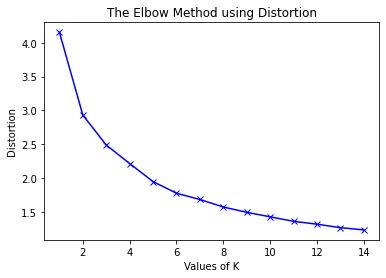

In [ ]:
distortions = []
mapping1 = {}
K = range(1, 15)
scaler=sklearn.preprocessing.MinMaxScaler()

data_cluster_weather=data_weather.loc[:,["start_hour","weekday","member_casual_enc","Precipitation","Snow","start_lat","start_lng","end_lat","end_lng"]]

data_cluster_weather.loc[:,["start_hour","weekday","Precipitation","Snow","start_lat","start_lng","end_lat","end_lng"]]=scaler.fit_transform(data_cluster_weather.loc[:,["start_hour","weekday","Precipitation","Snow","start_lat","start_lng","end_lat","end_lng"]])

data_cluster_weather.loc[:,["start_lat","start_lng","end_lat","end_lng"]]=data_cluster_weather.loc[:,["start_lat","start_lng","end_lat","end_lng"]]/2

for k in K:
    kmeanModel = sklearn.cluster.KMeans(n_clusters=k,random_state=12910).fit(data_cluster_weather)
    kmeanModel.fit(data_cluster_weather)
 
    distortions.append(sum(np.min(cdist(data_cluster_weather, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / data_cluster_weather.shape[0]) 
    mapping1[k] = sum(np.min(cdist(data_cluster_weather, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / data_cluster_weather.shape[0]

for key, val in mapping1.items():
    print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()


We copy and scale the data as explained in the report.

In [ ]:
data_cluster_weather=data_weather.loc[:,["start_hour","weekday","member_casual_enc","Precipitation","Snow","start_lat","start_lng","end_lat","end_lng"]].copy()

data_cluster_weather.loc[:,["start_hour","weekday","Precipitation","Snow","start_lat","start_lng","end_lat","end_lng"]]=scaler.fit_transform(data_cluster_weather.loc[:,["start_hour","weekday","Precipitation","Snow","start_lat","start_lng","end_lat","end_lng"]])

data_cluster_weather.loc[:,["start_lat","start_lng","end_lat","end_lng"]]=data_cluster_weather.loc[:,["start_lat","start_lng","end_lat","end_lng"]]/2

We run our clustering and assign clusters to each observation.

In [ ]:
kmeans=sklearn.cluster.KMeans(n_clusters=8, random_state=15)

kmeans.fit(data_cluster_weather)

data_cluster_weather.loc[:,"cluster"]=kmeans.predict(data_cluster_weather)

We reverse the scaling.

In [ ]:
data_cluster_weather.loc[:,["start_hour","weekday","Precipitation","Snow","start_lat","start_lng","end_lat","end_lng"]]=scaler.inverse_transform(data_cluster_weather.loc[:,["start_hour","weekday","Precipitation","Snow","start_lat","start_lng","end_lat","end_lng"]])

We look at the mean of the variables of interest.

In [ ]:
data_cluster_weather.groupby("cluster").aggregate("mean","count")

,start_hour,weekday,member_casual_enc,Precipitation,Snow,start_lat,start_lng,end_lat,end_lng
cluster,,,,,,,,,
0,14.810727,0.978842,0,0.023104,0.000779,38.841633,-77.202236,38.841071,-77.201927
1,9.379898,1.098204,1,0.045631,0.004504,38.844256,-77.199726,38.842860,-77.200637
2,14.250042,5.423992,0,0.012805,0.000469,38.840190,-77.202552,38.839575,-77.202257
3,14.866767,5.491965,1,0.032369,0.001730,38.843115,-77.199594,38.842636,-77.199384
4,14.953224,3.535300,0,0.017098,0.007454,38.842064,-77.201817,38.841327,-77.201687
5,17.282812,3.021910,1,0.041091,0.000645,38.843586,-77.200213,38.843491,-77.199525
6,17.197825,0.537447,1,0.008417,0.000570,38.843084,-77.200267,38.843115,-77.199508
7,8.859675,3.913729,1,0.065571,0.036877,38.844551,-77.199501,38.843181,-77.200110


# Second clustering

We again perform and plot the elbow method using distortion to check the optimal number of clusters.

1 : 4.51058825552743
2 : 3.0345232132076787
3 : 2.55683893601383
4 : 2.381418215590355
5 : 2.078784308352214
6 : 1.843953912118703
7 : 1.6466610516263667
8 : 1.5296930120995937
9 : 1.4366349805104044
10 : 1.3768086631327932
11 : 1.2832359171114354
12 : 1.2381113623715962
13 : 1.1859287304351782
14 : 1.1474633689388296


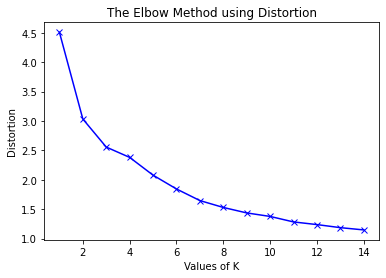

In [ ]:
distortions = []
mapping1 = {}
K = range(1, 15)

data_cluster_noweather=data.loc[:,["weekday","start_hour", "start_lat","start_lng","end_lat","end_lng"]].copy()

data_cluster_noweather.loc[:,["weekday","start_hour","start_lat","start_lng","end_lat","end_lng"]]=scaler.fit_transform(data_cluster_noweather.loc[:,["weekday","start_hour","start_lat","start_lng","end_lat","end_lng"]])

data_cluster_noweather.loc[:,["start_lat","start_lng","end_lat","end_lng"]]=data_cluster_noweather.loc[:,["start_lat","start_lng","end_lat","end_lng"]]/2

for k in K:
    kmeanModel = sklearn.cluster.KMeans(n_clusters=k,random_state=12).fit(data_cluster_noweather)
    kmeanModel.fit(data_cluster_noweather)
 
    distortions.append(sum(np.min(cdist(data_cluster_noweather, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / data_cluster_noweather.shape[0]) 
    mapping1[k] = sum(np.min(cdist(data_cluster_noweather, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / data_cluster_noweather.shape[0]

import matplotlib.pyplot as plt
for key, val in mapping1.items():
    print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

We follow a similar procedure to before and run our second clustering.

In [ ]:
data_cluster_noweather=data.loc[:,["weekday","start_hour", "start_lat","start_lng","end_lat","end_lng"]].copy()

data_cluster_noweather.loc[:,["weekday","start_hour","start_lat","start_lng","end_lat","end_lng"]]=scaler.fit_transform(data_cluster_noweather.loc[:,["weekday","start_hour","start_lat","start_lng","end_lat","end_lng"]])

kmeans=sklearn.cluster.KMeans(n_clusters=8, random_state=20)

kmeans.fit(data_cluster_noweather)

data_cluster_noweather["cluster"]=kmeans.predict(data_cluster_noweather)

data_cluster_noweather.loc[:,["weekday","start_hour","start_lat","start_lng","end_lat","end_lng"]]=scaler.inverse_transform(data_cluster_noweather.loc[:,["weekday","start_hour","start_lat","start_lng","end_lat","end_lng"]])

We look at the summary statistics, by cluster, of `start_hour` and `weekday`.

In [ ]:
data_cluster_noweather.groupby("cluster").describe()[["start_hour","weekday"]]

start_hour                                   ... weekday                    
             count       mean       std   min   25%  ...     min  25%  50%  75%  max
cluster                                              ...                            
0          64381.0   1.801168  1.960109   0.0   0.0  ...     3.0  5.0  5.0  6.0  6.0
1         290390.0  10.534123  2.521691   3.0   8.0  ...     3.0  3.0  4.0  4.0  4.0
2         397084.0  17.320615  2.425293  13.0  16.0  ...     0.0  0.0  1.0  1.0  1.0
3         401115.0  11.571362  1.903248   6.0  10.0  ...     5.0  5.0  5.0  6.0  6.0
4         369600.0  18.101337  2.230353  15.0  16.0  ...     3.0  3.0  4.0  4.0  4.0
5         392404.0  17.759378  2.315284  15.0  16.0  ...     5.0  5.0  5.0  6.0  6.0
6         220382.0  16.906735  2.841537  12.0  15.0  ...     2.0  2.0  2.0  2.0  2.0
7         325139.0   8.893722  2.651249   0.0   7.0  ...     0.0  0.0  1.0  2.0  2.0

[8 rows x 16 columns]

We look at the summary statistics, by cluster, of `member_casual_enc`.

In [ ]:
data_cluster_noweather_done=pd.concat([data_cluster_noweather[["cluster"]],data],axis=1)

data_cluster_noweather_done.groupby("cluster").describe()["member_casual_enc"]

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,64381.0,0.470123,0.499110,0.0,0.0,0.0,1.0,1.0
1,290390.0,0.628486,0.483210,0.0,0.0,1.0,1.0,1.0
2,397084.0,0.605978,0.488640,0.0,0.0,1.0,1.0,1.0
3,401115.0,0.489426,0.499889,0.0,0.0,0.0,1.0,1.0
4,369600.0,0.586991,0.492375,0.0,0.0,1.0,1.0,1.0
5,392404.0,0.473280,0.499286,0.0,0.0,0.0,1.0,1.0
6,220382.0,0.623068,0.484619,0.0,0.0,1.0,1.0,1.0
7,325139.0,0.664611,0.472127,0.0,0.0,1.0,1.0,1.0


# Plotting Functions

In [ ]:
def zoom_center(lons: tuple=None, lats: tuple=None, lonlats: tuple=None,
        format: str='lonlat', projection: str='mercator',
        width_to_height: float=2.0) -> (float, dict):
    """Finds optimal zoom and centering for a plotly mapbox.
    Must be passed (lons & lats) or lonlats.
    Temporary solution awaiting official implementation, see:
    https://github.com/plotly/plotly.js/issues/3434
    
    Parameters
    --------
    lons: tuple, optional, longitude component of each location
    lats: tuple, optional, latitude component of each location
    lonlats: tuple, optional, gps locations
    format: str, specifying the order of longitud and latitude dimensions,
        expected values: 'lonlat' or 'latlon', only used if passed lonlats
    projection: str, only accepting 'mercator' at the moment,
        raises `NotImplementedError` if other is passed
    width_to_height: float, expected ratio of final graph's with to height,
        used to select the constrained axis.
    
    Returns
    --------
    zoom: float, from 1 to 20
    center: dict, gps position with 'lon' and 'lat' keys

    >>> print(zoom_center((-109.031387, -103.385460),
    ...     (25.587101, 31.784620)))
    (5.75, {'lon': -106.208423, 'lat': 28.685861})
    """
    if lons is None and lats is None:
        if isinstance(lonlats, tuple):
            lons, lats = zip(*lonlats)
        else:
            raise ValueError(
                'Must pass lons & lats or lonlats'
            )
    
    maxlon, minlon = max(lons), min(lons)
    maxlat, minlat = max(lats), min(lats)
    center = {
        'lon': round((maxlon + minlon) / 2, 6),
        'lat': round((maxlat + minlat) / 2, 6)
    }
    
    # longitudinal range by zoom level (20 to 1)
    # in degrees, if centered at equator
    lon_zoom_range = np.array([
        0.0007, 0.0014, 0.003, 0.006, 0.012, 0.024, 0.048, 0.096,
        0.192, 0.3712, 0.768, 1.536, 3.072, 6.144, 11.8784, 23.7568,
        47.5136, 98.304, 190.0544, 360.0
    ])
    
    if projection == 'mercator':
        margin = 1.2
        height = (maxlat - minlat) * margin * width_to_height
        width = (maxlon - minlon) * margin
        lon_zoom = np.interp(width , lon_zoom_range, range(20, 0, -1))
        lat_zoom = np.interp(height, lon_zoom_range, range(20, 0, -1))
        zoom = round(min(lon_zoom, lat_zoom), 2)
    else:
        raise NotImplementedError(
            f'{projection} projection is not implemented'
        )
    
    return zoom, center

In [ ]:
def plot_start_points(data):
    tstart=list()
    for i in list(data["start_station_name"].unique()):
          tstart.append([i,np.sum(data["start_station_name"]==i)])
    datastat=pd.DataFrame()

    datastat["start_long"],datastat["start_lat"], datastat["start_count"], datastat["start_stat_name"]=0,0,0,0


    for i in range(len(tstart)):
        datastat.loc[i] = [data[data["start_station_name"]==tstart[i][0]]["start_lng"].mean(), 
                     data[data["start_station_name"]==tstart[i][0]]["start_lat"].mean(), 
                     tstart[i][1], 
                     tstart[i][0],
                     ]

    datanonstat = pd.DataFrame({'start_long': data[data["start_station_name"].isnull()]["start_lng"],
                   'start_lat':  data[data["start_station_name"].isnull()]["start_lat"],
                   'start_count': np.repeat(1,len(data[data["start_station_name"].isnull()]["start_lng"])), 
                   "start_stat_name":np.repeat("Undocked",len(data[data["start_station_name"].isnull()]["start_lng"]))})

    datastat=datastat.append(datanonstat, ignore_index = True)
    
    geometry = [Point(xy) for xy in zip(datastat['start_long'], datastat['start_lat'])]
    gdf = GeoDataFrame(datastat, geometry=geometry)   
    
    fig = px.scatter_mapbox(gdf,lat=gdf.geometry.y,lon=gdf.geometry.x, size="start_count",hover_name="start_stat_name", color="start_count")
    fig.update_layout(mapbox_style="open-street-map", autosize=False,
    width=750,
    height=750)
    
    return fig, datastat


In [ ]:
def plot_end_points(data):
    tend=list()
    for i in list(data["end_station_name"].unique()):
      tend.append([i,np.sum(data["end_station_name"]==i)])


    datastatend=pd.DataFrame()

    datastatend["end_long"],datastatend["end_lat"], datastatend["end_count"], datastatend["end_stat_name"]=0,0,0,0

    for i in range(len(tend)):
        datastatend.loc[i]=[data[data["end_station_name"]==tend[i][0]]["end_lng"].mean(), 
                      data[data["end_station_name"]==tend[i][0]]["end_lat"].mean(), 
                      tend[i][1], 
                      tend[i][0]]



    datanonstatend = pd.DataFrame({'end_long': data[data["end_station_name"].isnull()]["end_lng"], 
                                'end_lat':  data[data["end_station_name"].isnull()]["end_lat"],
                                'end_count': np.repeat(1,len(data[data["end_station_name"].isnull()]["end_lng"])),
                                "end_stat_name":np.repeat("Undocked",len(data[data["end_station_name"].isnull()]["end_lng"]))})


    datastatend=datastatend.append(datanonstatend, ignore_index = True)

    geometry = [Point(xy) for xy in zip(datastatend['end_long'], datastatend['end_lat'])]
    gdf = GeoDataFrame(datastatend, geometry=geometry)   

    fig = px.scatter_mapbox(gdf,lat=gdf.geometry.y,lon=gdf.geometry.x, size="end_count",hover_name="end_stat_name", color="end_count")
    fig.update_layout(mapbox_style="open-street-map", autosize=False,
        width=750,
        height=750)

    return fig, datastatend

In [ ]:

def plot_route_heatmap(data,mostpopn=1000,size_lines=50):
    #The function returns a plot with the mostpopn (1000 by default) popular rides (note these will only include rides from one station to another)
    tstart=list()
    for i in list(data["start_station_name"].unique()):
        tstart.append([i,np.sum(data["start_station_name"]==i)])

    tend=list()
    for i in list(data["end_station_name"].unique()):
        tend.append([i,np.sum(data["end_station_name"]==i)])

    tfinal=list(product(np.array(tstart)[:,0], np.array(tend)[:,0]))

    tfinal=pd.DataFrame(tfinal)

    tfinalap=list()
    for i in tstart:
        for j in tend:
            tfinalap.append(sum((data["start_station_name"]==i[0]) & (data["end_station_name"]==j[0])))

    tfinal["2"]=tfinalap

    ttouse=tfinal.sort_values(by="2",ascending=False).iloc[:mostpopn]

    ttouse=pd.concat([pd.DataFrame(),ttouse], ignore_index = True)

    ttouse.columns=["Start","End","Count"]
    datastatfin=pd.DataFrame()

    datastatfin["start_lat"], datastatfin["start_long"],datastatfin["start_stat"],datastatfin["end_lat"],datastatfin["end_long"],datastatfin["end_stat"], datastatfin["count"]=0,0,0,0,0,0,0

    for i in range(len(ttouse)):
        datastatfin.loc[i]=[data[data["start_station_name"]==ttouse.iloc[i][0]]["start_lat"].mean(), 
                    data[data["start_station_name"]==ttouse.iloc[i][0]]["start_lng"].mean(), 
                    ttouse.iloc[i][0], 
                    data[data["end_station_name"]==ttouse.iloc[i][1]]["end_lat"].mean(), 
                    data[data["end_station_name"]==ttouse.iloc[i][1]]["end_lng"].mean(),
                    ttouse.iloc[i][1],
                    ttouse.iloc[i][2]]

    topstations=np.unique(np.array([ttouse["Start"],ttouse["End"]]).reshape(2*mostpopn))

    datastations=pd.DataFrame()

    datastations["station"],datastations["long"],datastations["lat"]=0,0,0

    for i in range(len(topstations)):
        datastations.loc[i]=[topstations[i],
                            data[data["start_station_name"]==topstations[i]]["start_lng"].mean(),
                            data[data["start_station_name"]==topstations[i]]["start_lat"].mean()]

    zoom, center = zoom_center(
        lons=datastations['long'],
        lats=datastations['lat']
    )

    fig= go.Figure()

    for i in range(len(datastatfin)):
        fig.add_trace(
            go.Scattermapbox(
                lon = [datastatfin['start_long'][i], datastatfin['end_long'][i]],
                lat = [datastatfin['start_lat'][i], datastatfin['end_lat'][i]],            
                mode = 'lines',

                line = dict(width = float(datastatfin['count'][i]) / float(datastatfin['count'].max())*size_lines,color = 'red'),
                opacity = float(datastatfin['count'][i]) / float(datastatfin['count'].max())
            )
    )

    fig.add_trace(go.Scattermapbox(
        lon = datastations['long'],
        lat = datastations['lat'],
        hoverinfo = 'text',
        text = datastations['station'],
        mode = 'markers',
        marker = dict(
            size = 4,
            color = 'rgb(255, 0, 0)'),
            line = dict(
                width = 3,
                color = 'rgba(68, 68, 68, 0)'
            )
        )) 

    fig.update_layout(mapbox_style="open-street-map", width=1000,height=1000)
    fig.update_mapboxes(center=center, zoom=zoom)

    return fig,datastations, datastatfin

# Clustering Plots

We prepare the data to plot the results of our clustering.

In [ ]:
plot_data=data_cluster_noweather_done.sample(50000,axis=0,random_state=2679)
plot_data_cluster0=data_cluster_noweather_done[data_cluster_noweather_done["cluster"]==0].sample(50000,random_state=345)

We plot the starting stations in both the whole dataset and our cluster of interest.

In [ ]:
fig1,_=plot_start_points(plot_data)
fig2,_=plot_start_points(plot_data_cluster0)

fig1.update_layout(title_text='Starting stations in the whole dataset') 
fig2.update_layout(title_text='Starting stations in cluster 0') 

fig1.show()
fig2.show()

We plot the most popular routes in both the whole dataset and our cluster of interest.

In [39]:
plot_data_reduced=data_cluster_noweather_done.sample(20000,random_state=3111)
plot_data_cluster0_reduced=data_cluster_noweather_done[data_cluster_noweather_done["cluster"]==0].sample(20000,random_state=3111)

fig3,_,_=plot_route_heatmap(plot_data_reduced,500,30)
fig4,_,_=plot_route_heatmap(plot_data_cluster0_reduced,500,30)

fig3.show()
fig4.show()

# Nightlife spots clustering

We import the dataset on which to perform this clustering and drop all the NAs.

In [40]:
locations = pd.read_excel("/content/locations_withLL_complete.xlsx")
locations.dropna(inplace=True)

We ensure langitude and longitude are of the same length as the one Python expects.

In [41]:
import math
locations = locations[["latitude","longitude","Establishment Type","Status"]]

def truncate(x):
  a = str(x)
  b = a[:6]
  n = int(b)/10000
  return n

def truncate_long(x):
  a = str(x)
  b = a[1:7]
  n = int(b)/10000
  return -n 
locations['lat']= locations['latitude'].apply(truncate)

locations['long']= locations['longitude'].apply(truncate_long)

We keep only the locations for which the status of the license is Active, rename Nightclubs to clubs, and filter out all the types of establishment we won't condsider in our analysis.

In [ ]:
locations = locations[locations['Status'] == 'Active']
del locations['Status']
locations['Establishment Type'].unique()
del locations['latitude']
del locations['longitude']
locations["Establishment Type"].replace({"Nightclub":"Club"},inplace=True)
locations_all = locations[locations['Establishment Type'].isin(['Club','Tavern','Nightclub','Hotel','Restaurant'])].copy()
locations = locations[locations['Establishment Type'].isin(['Club','Tavern','Nightclub'])]

We perform and plot the elbow method using distortion.

1 : 0.18867129388607146
2 : 0.13526779318458065
3 : 0.11172448225725791
4 : 0.0987944040673836
5 : 0.08544959480538329
6 : 0.07962745681587761
7 : 0.07318616824837801
8 : 0.06596561841989695
9 : 0.06238003874093469
10 : 0.057916362330781436
11 : 0.056622541652556556
12 : 0.0519398807478062
13 : 0.04794351865128075
14 : 0.04631286044735966


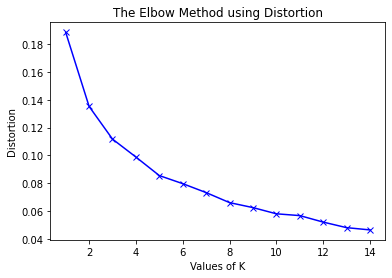

In [43]:
distortions = []
mapping1 = {}
K = range(1, 15)
 
locations[["lat_s","long_s"]] = scaler.fit_transform(locations[["lat","long"]])

data = locations[["lat_s","long_s"]].copy()

for k in K:
    kmeanModel = sklearn.cluster.KMeans(n_clusters=k,random_state=12).fit(data)
    kmeanModel.fit(data)
 
    distortions.append(sum(np.min(cdist(data, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / data.shape[0]) 
    mapping1[k] = sum(np.min(cdist(data, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / data.shape[0]

import matplotlib.pyplot as plt
for key, val in mapping1.items():
    print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

We perform the k-means clustering.

In [44]:
kmeanModel = sklearn.cluster.KMeans(n_clusters=4,random_state=12).fit(data)
kmeanModel.fit(data)
locations["Cluster"] = kmeanModel.fit_predict(locations[["lat_s","long_s"]])

We look at where locations are based on establishment.

In [45]:
def plot_est(data):
    lst_colors = ["#092242","#f7ac2d","#609a92","#ed0f51"]
    lst_elements = sorted(list(data["Establishment Type"].unique()))

    data["Color"] = data["Establishment Type"].apply(lambda x: lst_colors[lst_elements.index(x)])
    fig= go.Figure()

    fig.update_layout(mapbox_style="open-street-map", width=1000,height=1000,showlegend=True)

    
    zoom, center = zoom_center(
        lons=data['long'],
        lats=data['lat']
    )


    fig.add_trace(go.Scattermapbox(
        lon = data[data["Establishment Type"]=="Hotel"]['long'],
        lat = data[data["Establishment Type"]=="Hotel"]['lat'],
        hoverinfo = 'text',
        text = data[data["Establishment Type"]=="Hotel"]["Establishment Type"],
        mode = 'markers',
        name="Hotel",
        
        marker = dict(
            size = 11,
            color = data[data["Establishment Type"]=="Hotel"]['Color'])

        ))  
    

    fig.add_trace(go.Scattermapbox(
        lon = data[data["Establishment Type"]=="Restaurant"]['long'],
        lat = data[data["Establishment Type"]=="Restaurant"]['lat'],
        hoverinfo = 'text',
        text = data[data["Establishment Type"]=="Restaurant"]["Establishment Type"],
        mode = 'markers',
        name = "Restaurant",
        marker = dict(
            size = 11,
            color = data[data["Establishment Type"]=="Restaurant"]['Color'])

        ))  
    
    fig.add_trace(go.Scattermapbox(
        lon = data[data["Establishment Type"]=="Club"]['long'],
        lat = data[data["Establishment Type"]=="Club"]['lat'],
        hoverinfo = 'text',
        text = data[data["Establishment Type"]=="Club"]["Establishment Type"],
        mode = 'markers',
        name ="Club",
        marker = dict(
            size = 11,
            color = data[data["Establishment Type"]=="Club"]['Color'])

        ))  
    
    fig.add_trace(go.Scattermapbox(
        lon = data[data["Establishment Type"]=="Tavern"]['long'],
        lat = data[data["Establishment Type"]=="Tavern"]['lat'],
        hoverinfo = 'text',
        text = data[data["Establishment Type"]=="Tavern"]["Establishment Type"],
        name = "Tavern",
        mode = 'markers',
        marker = dict(
            size = 11,
            color = data[data["Establishment Type"]=="Tavern"]['Color'])

        )) 
    fig.update_mapboxes(center=center, zoom=zoom)
    
    #color =data["Color"]
    
    return fig



plot_est(locations_all).show()

We look at the results of the clustering.

In [46]:
def plot(data):
    lst_colors = ["#092242","#f7ac2d","#609a92","#ed0f51"]
    lst_elements = sorted(list(data["Cluster"].unique()))

    data["Color"] = data["Cluster"].apply(lambda x: lst_colors[lst_elements.index(x)])
    fig= go.Figure()

    fig.update_layout(mapbox_style="open-street-map", width=1000,height=1000)
    
    fig.add_trace(go.Scattermapbox(
        lon = data['long'],
        lat = data['lat'],
        hoverinfo = 'text',
        text = data["Cluster"],
        mode = 'markers',
        marker = dict(
            size = 9,
            color =data["Color"])

        ))    
    zoom, center = zoom_center(
        lons=data['long'],
        lats=data['lat']
    )
    
    fig.update_mapboxes(center=center, zoom=zoom) 

    return fig
plot(locations).show()

We look at how clubs and taverns are spread among clusters.

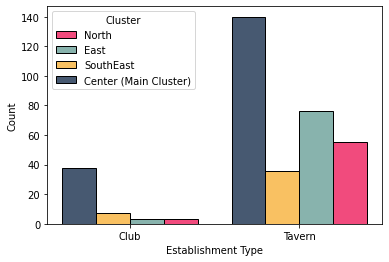

In [47]:
sns_plot = sns.histplot(data=locations, x="Establishment Type", hue="Cluster", multiple="dodge", shrink=.8,palette= ["#092242","#f7ac2d","#609a92","#ed0f51"])
plt.legend(title='Cluster', loc='upper left', labels=['North','East','SouthEast','Center (Main Cluster)'])
plt.show()

In [48]:
print("Center (Main Cluster) composition:")
locations[locations["Cluster"]==0]["Establishment Type"].value_counts(normalize=True)

Center (Main Cluster) composition:


Tavern    0.786517
Club      0.213483
Name: Establishment Type, dtype: float64

In [49]:
print("SouthEast cluster composition:")
locations[locations["Cluster"]==1]["Establishment Type"].value_counts(normalize=True)

SouthEast cluster composition:


Tavern    0.837209
Club      0.162791
Name: Establishment Type, dtype: float64

In [50]:
print("East cluster composition:")
locations[locations["Cluster"]==2]["Establishment Type"].value_counts(normalize=True)

East cluster composition:


Tavern    0.962025
Club      0.037975
Name: Establishment Type, dtype: float64

In [51]:
print("North cluster composition:")
locations[locations["Cluster"]==3]["Establishment Type"].value_counts(normalize=True)

North cluster composition:


Tavern    0.948276
Club      0.051724
Name: Establishment Type, dtype: float64